# Test: Multiple Counties
* Find where providers don't have service in several counties before applying functions to the entire state.

In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import *
from shared_utils import geography_utils
from shared_utils import utils 
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import folium

In [3]:
ca_counties = utilities.get_counties()

In [4]:
# Replace spaces with _ 
ca_counties['county_name'] = ca_counties['county_name'].str.replace(' ','_')

In [5]:
# Read in ATT
att = dg.read_parquet("ATT.parquet")

## Test with Districts

In [6]:
Caltrans_shape = "https://gis.data.ca.gov/datasets/0144574f750f4ccc88749004aca6eb0c_0.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
ct_districts = to_snakecase(gpd.read_file(f'{Caltrans_shape}')
               .to_crs(epsg=4326))[['district','geometry']]

In [30]:
ct_districts.loc[ct_districts.district == 7].explore()

In [7]:
my_list = list(range(1, 13))

In [8]:
att_all = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet"
)

<AxesSubplot:>

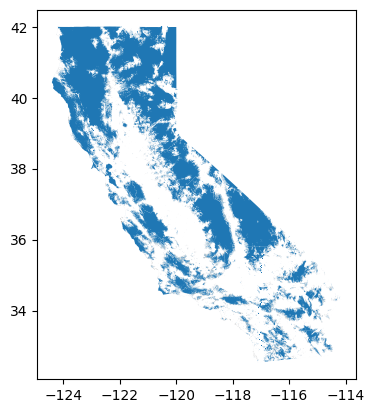

In [9]:
att_all.plot()

In [10]:
#test_d7_d3.plot()

In [11]:
routes_df = utilities.load_unique_routes_df()

In [12]:
# Routes from analysis v1 that didn't make sense
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
    "Roseville Transit",
    "Los Angeles Department of Transportation"
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Long Beach/San Pedro"
]


def subset_routes(routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
    ]
    return routes_subset


routes_subset = subset_routes(routes_wanted)

In [13]:
routes_subset.columns

Index(['itp_id', 'route_id', 'geometry', 'route_name', 'agency',
       'original_route_length'],
      dtype='object')

In [14]:
clipped = gpd.overlay(routes_subset, att_all, how="intersection")

In [15]:
clipped = clipped.assign(
        overlay_route_length=clipped.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [16]:
# Rename geometry before adding back original geometry 
clipped = clipped.rename(columns = {'geometry':'overlay_geometry'})

In [17]:
# Set geometry
clipped = clipped.set_geometry("overlay_geometry")

In [18]:
# Merge back old geometry
clipped2 = clipped.merge(
        routes_subset[['itp_id', 'route_id', 'geometry', 'route_name', 'agency']],
        how="left",
        on=['itp_id', 'route_id','route_name','agency'],
    )

In [19]:
clipped2 = clipped2.rename(columns = {'geometry':'original_geometry'}) 

In [20]:
# Calculate the %  the intersected geometry 
clipped2['percentage_route_length'] = (clipped2['overlay_route_length']/clipped['original_route_length'])*100

In [27]:
clipped2.shape

(3, 9)

In [21]:
clipped2

,itp_id,route_id,route_name,agency,original_route_length,overlay_geometry,overlay_route_length,original_geometry,percentage_route_length
0,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation ...,56918.543438,"MULTILINESTRING ((-122.32825 37.82216, -122.32...",18054.623012,"LINESTRING (-122.26642 37.82804, -122.26642 37...",31.720107
1,183,870,Long Beach/San Pedro,Los Angeles Department of Transportation,45275.955178,"LINESTRING (-118.22198 33.76428, -118.22279 33...",15625.055779,"LINESTRING (-118.19017 33.76813, -118.19097 33...",34.510715
2,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.128572,"MULTILINESTRING ((-119.62221 37.72721, -119.62...",333471.798546,"LINESTRING (-119.58867 37.74998, -119.58848 37...",52.580151


In [29]:
# https://stackoverflow.com/questions/73767559/geopandas-explore-how-to-plot-more-than-one-layer
(clipped2.set_geometry('overlay_geometry').explore('route_name',
               width=800,
    height=400,
    tooltip=["route_name", "agency", "route_id"],
    style_kwds={"weight": 6},
    legend=False,
    color="tab10c",
    name = "Clipped"))

In [28]:
(clipped2.set_geometry('original_geometry').explore('route_name',
               width=800,
    height=400,
    tooltip=["route_name", "agency", "route_id"],
    style_kwds={"weight": 6},
    legend=False,
    color="tab20c",
    name = "Original"))

In [26]:
folium.LayerControl().add_to(my_map)

## Go through several counties

In [ ]:
# Grab all counties in SF 
ca_counties_list = ca_counties.county_name.unique().tolist()

In [ ]:
# Subset
ca_counties_list = ['Alameda','San_Francisco','Los_Angeles', 'Placer', 'Mariposa']

In [ ]:
# Filter ca_counties gdf for each county 
for i in ca_counties_list:
    exec(f"{i}_gdf = ca_counties[ca_counties['county_name']== i].reset_index(drop=True)")

In [ ]:
# Create a list to hold each dataframe 
string = '_gdf'
counties_gdf_list = [x + string for x in ca_counties_list]

In [ ]:
# Apply function to each gdf
for county in counties_gdf_list:
    exec(f"{county} = (utilities.find_difference_and_clip(att, {county}))")

In [ ]:
# Compare LA with debug_ah.ipynb results
# Blue are areas that are in LA County but aren't covered by AT&T
# This is accurate
Los_Angeles_gdf.plot()

In [ ]:
# Remove quotes from list, since these aren't strings. They are dataframes. 
counties_gdf_list = [Alameda_gdf, San_Francisco_gdf, Los_Angeles_gdf, Placer_gdf, Mariposa_gdf]

In [ ]:
# Concat using dask 
# https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/gtfs_utils.py#L563-L564
att_concat = dd.multi.concat(counties_gdf_list, axis=0)

In [ ]:
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.dissolve.html
att_concat.dissolve(split_out=1)

In [ ]:
att_concat_gpd = att_concat.compute()

In [ ]:
att_concat_gpd = att_concat_gpd.dissolve().drop(columns = ['county_name'])

In [ ]:
att_concat_gpd.plot()

In [ ]:
routes_df = utilities.load_unique_routes_df()

In [ ]:
# TopologyException: side location conflict at -118.658061 34.07038. This can occur if the input geometry is invalid.

In [ ]:
# o1 = gpd.overlay(routes_df, att_concat_gpd, how="intersection")

### Testing with subset

In [ ]:
counties_wanted = ['San_Francisco','Los_Angeles','San_Mateo', 'Placer', 'Mariposa']
# Subset to a few counties
ca_subset = ca_counties[ca_counties["county_name"].isin(counties_wanted)]

In [ ]:
test = utilities.find_difference_and_clip(att, ca_subset)

In [ ]:
test = test.dissolve().drop(columns = ['county_name'])

In [ ]:
test == att_concat_gpd

In [ ]:
test.plot()

In [ ]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
    "Roseville Transit"
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "None"
]


def subset_routes(agency_wanted, routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
        & routes_df["agency"].isin(agency_wanted)
    ]
    return routes_subset


routes_subset = subset_routes(agency_wanted, routes_wanted)

In [ ]:
o2 = gpd.overlay(routes_subset, test, how="intersection")

In [ ]:
o2 = o2.assign(
        overlay_route_length=o2.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [ ]:
# Calculate the length of the intersected geometry 
o2['percentage_route_length'] = o2['overlay_route_length']/o2['original_route_length']
# Subtract percentage of length to find portion of route that IS covered by provider'
o2['percentage_covered_by_provider'] = 1 - o2['percentage_route_length']

In [ ]:
# Subtract percentage of length to find portion of route that IS covered by provider'
o2['percentage_covered_by_provider'] = 1 - o2['percentage_route_length']

In [ ]:
o2